In [217]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from datetime import datetime, date, time, timedelta
from collections import defaultdict


In [218]:
pd.set_option("display.max_rows", 101)

In [219]:
def count_entries(frame):
    """Calculates the number of entries between rows of a dataframe."""
    counts = pd.Series(index=frame.index)
    last_scp = ''
    last_entry_count = 0
    for index, row in frame.iterrows():
        if row['SCP'] != last_scp:
            counts[index] = 0
            last_scp = row['SCP']
            last_entry_count = row['ENTRIES']
        else:
            counts[index] = abs(row['ENTRIES'] - last_entry_count)
            last_scp = row['SCP']
            last_entry_count = row['ENTRIES']
    return counts

In [220]:
def sample(frame, index):
    """Returns three lines from a dataframe centered around the index parameter"""
    return frame.loc[index-1:index+1]

In [221]:
def am_pm(datetime_series):
    s = pd.Series(index=datetime_series.index)
    for index, value in datetime_series.items():
        entry_time = datetime_series[index].time()
        if  entry_time > time(12,0,0) or entry_time == time(0,0,0):
            s[index] = 'PM'
        else:
            s[index] = 'AM'
    return s

In [222]:
# Read data files
# list_of_data_files = glob('../data/*.txt')
list_of_data_files = glob('../data/turnstile_190330.txt')
list_of_data_files

# Read data files into pandas dataframes
list_of_dataframes = [pd.read_csv(file) for file in list_of_data_files]
df = pd.concat(list_of_dataframes)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573


In [223]:
# Clean up strange spaces in column names
df.columns = df.columns.str.strip()
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [234]:
# Add a weekday column
df['DATE_TIME'] = df['DATE'] + ' ' + df['TIME']
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['WEEKDAY'] = df['DATE_TIME'].dt.day_name()

In [235]:
# Limit to one station for simplicity
# df = df[df['STATION'] == '59 ST']

In [236]:
# Filter out df['DESC'] == 'RECOVR AUD'. These entries create large jumps in entry counts
df = df[df['DESC'] != 'RECOVR AUD']

In [237]:
len(df.STATION.unique())

377

In [238]:
df['ENTRY_COUNTS'] = count_entries(df)

In [239]:
# Filter out ENTRY_COUNTS greater than 3000 because these are usually counter resets
df = df[df['ENTRY_COUNTS'] < 3000]

In [240]:
df[df['ENTRY_COUNTS'] < 0]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,WEEKDAY,ENTRY_COUNTS,AM/PM


In [241]:
print(df['ENTRY_COUNTS'].min(), df['ENTRY_COUNTS'].max()) 

0.0 2990.0


In [242]:
df['AM/PM'] = am_pm(df['DATE_TIME'])

In [243]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,WEEKDAY,ENTRY_COUNTS,AM/PM
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,2019-03-23 00:00:00,Saturday,0.0,PM
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,2019-03-23 04:00:00,Saturday,21.0,AM
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,2019-03-23 08:00:00,Saturday,18.0,AM
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,2019-03-23 12:00:00,Saturday,111.0,AM
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,2019-03-23 16:00:00,Saturday,276.0,PM


In [246]:
gp = df.groupby(['STATION', 'WEEKDAY', 'AM/PM'], as_index=False).sum()

In [248]:
gp.head(100)

,STATION,WEEKDAY,AM/PM,ENTRIES,EXITS,ENTRY_COUNTS
0,1 AV,Friday,AM,6156038749,6428056953,6568.0
1,1 AV,Friday,PM,4238401848,4388746635,15028.0
2,1 AV,Monday,AM,4238139287,4388461145,7009.0
3,1 AV,Monday,PM,3784242656,3945266271,11750.0
4,1 AV,Saturday,AM,4238066180,4388375450,2646.0
5,1 AV,Saturday,PM,4238077335,4388388930,7164.0
6,1 AV,Sunday,AM,4238104558,4388418303,2364.0
7,1 AV,Sunday,PM,4238113851,4388429979,9049.0
8,1 AV,Thursday,AM,4238317041,4388655977,6682.0
9,1 AV,Thursday,PM,4238337419,4388675867,14111.0


In [250]:
gp_sorted = gp.sort_values(['ENTRY_COUNTS'], ascending=False)

In [254]:
gp_sorted.nlargest(20, 'ENTRY_COUNTS')

,STATION,WEEKDAY,AM/PM,ENTRIES,EXITS,ENTRY_COUNTS
3257,GRD CNTRL-42 ST,Wednesday,PM,6890071782,5024722275,123874.0
3253,GRD CNTRL-42 ST,Thursday,PM,6897587669,5036072106,122715.0
3255,GRD CNTRL-42 ST,Tuesday,PM,6875532723,5002468376,120016.0
3245,GRD CNTRL-42 ST,Friday,PM,6896722784,5035650383,117211.0
3247,GRD CNTRL-42 ST,Monday,PM,6887372038,5022047902,112747.0
653,23 ST,Wednesday,PM,16950794425,18866586346,102088.0
649,23 ST,Thursday,PM,16950636782,18866542882,101618.0
651,23 ST,Tuesday,PM,16950423212,18866304030,99690.0
823,34 ST-HERALD SQ,Friday,PM,13832314664,17302639092,98694.0
835,34 ST-HERALD SQ,Wednesday,PM,13831625705,17301907061,97183.0


(array([1.45658e+05, 3.08570e+04, 1.42540e+04, 6.74900e+03, 3.43100e+03,
        1.64900e+03, 8.73000e+02, 5.03000e+02, 2.71000e+02, 1.42000e+02]),
 array([   0. ,  199.8,  399.6,  599.4,  799.2,  999. , 1198.8, 1398.6,
        1598.4, 1798.2, 1998. ]),
 <a list of 10 Patch objects>)

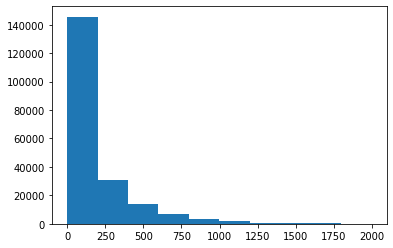

In [27]:
plt.hist(df.ENTRY_COUNTS[df.ENTRY_COUNTS < 2000])

In [ ]:
df = df[df['ENTRY_COUNTS'] < 4000]

In [ ]:
df.loc[36217:36221]

In [ ]:
df.ENTRY_COUNTS.median()

In [ ]:
df.ENTRY_COUNTS.mean()

In [ ]:
df.head()

In [ ]:
# Create a dict dataframes that contain the turnstile data for each station
dict_of_station_frames = {station : df[df.STATION == station] for station in df['STATION'].unique()}
len(dict_of_station_frames.keys())

In [ ]:
dict_of_station_frames['59 ST'].head()

In [ ]:
for name in dict_of_station_frames.keys():
    print(name + ':\n')
    print(dict_of_station_frames[name].describe())

In [ ]:
station_counts = defaultdict(int)
for name in dict_of_station_frames.keys():
    frame = dict_of_station_frames[name].copy()
    frame['ENTRY_COUNT'] = frame['ENTRIES'] - frame['ENTRIES'].shift(1)
    frame['ENTRY_COUNT'].fillna(0, inplace=True)
    dict_of_station_frames[name] = frame
    print(dict_of_station_frames[name].head(5))
    station_counts[name] = dict_of_station_frames[name]['ENTRY_COUNT'].sum()

In [ ]:
for key, value in station_counts.items():
    print(key, ':', value)

In [ ]:
for name in dict_of_station_frames.keys():
    

In [ ]:
df.head()

In [ ]:
# Filter data to daylight hours
times = ['12:00:00', '16:00:00', '20:00:00']
df = df[df['TIME'].isin(times)]

In [ ]:
gd = df.groupby(['STATION', 'WEEKDAY', 'TIME'], as_index=False).count()

In [ ]:
gd.head()